<a href="https://colab.research.google.com/github/hrumst/ML/blob/master/Competition_self_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive

DRIVE_MOUNT = './DRIVE/'
DRIVE_MOUNT_SAVE_MODEL_PATH = 'My Drive/Colab Notebooks/competition_7/brand-logo-detection-dataset.zip'
drive.mount(DRIVE_MOUNT, force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE/


In [3]:
!rm -rf input \
&& mkdir input \
&& unzip "./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip" -d input

Archive:  ./DRIVE/My Drive/competition_7/brand-logo-detection-dataset.zip
   creating: input/brand-logo-detection-dataset/
   creating: input/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4652863706.jpg  
   creating: input/__MACOSX/
   creating: input/__MACOSX/brand-logo-detection-dataset/
   creating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4652863706.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/4328758763.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._4328758763.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/320927855.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._320927855.jpg  
  inflating: input/brand-logo-detection-dataset/trainval_jpg/2653776560.jpg  
  inflating: input/__MACOSX/brand-logo-detection-dataset/trainval_jpg/._26537765

In [24]:
import sys
import os

ROOT_DIR = DRIVE_MOUNT + 'My Drive/colab_data/Mask_RCNN-master'
print(ROOT_DIR)
sys.path.insert(0, ROOT_DIR)
sys.path.insert(0, ROOT_DIR + '/mrcnn')

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

./DRIVE/My Drive/colab_data/Mask_RCNN-master


In [25]:
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

Using TensorFlow backend.


... done downloading pretrained model!


In [4]:
import pandas as pd

BASE_DATA_DIR = 'input/brand-logo-detection-dataset/'
df = pd.read_csv(BASE_DATA_DIR + 'trainval_bboxes.txt', header=None)
df.columns = ['image_id','brand_name','x', 'y', 'width', 'height']
df.head()

,image_id,brand_name,x,y,width,height
0,2325670467.jpg,google,51,198,892,342
1,2359495755.jpg,google,73,228,948,327
2,2727802511.jpg,google,68,72,854,311
3,321106127.jpg,google,461,354,519,203
4,343855903.jpg,google,176,104,686,413


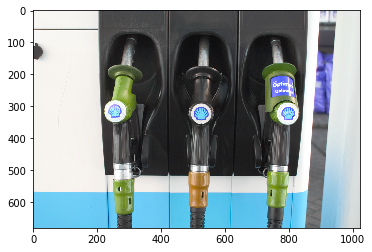

image_id      106310488.jpg
brand_name            shell
x                       233
y                       292
width                    49
height                   49
Name: 992, dtype: object


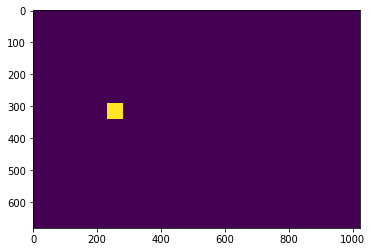

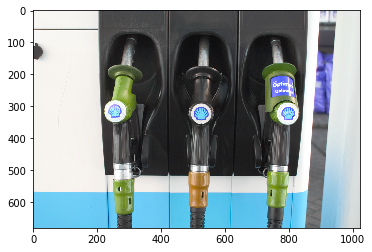

image_id      106310488.jpg
brand_name            shell
x                       503
y                       301
width                    49
height                   49
Name: 993, dtype: object


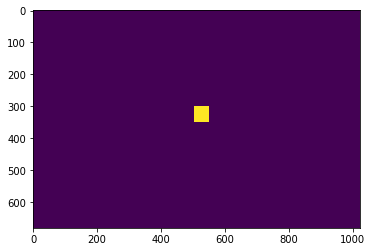

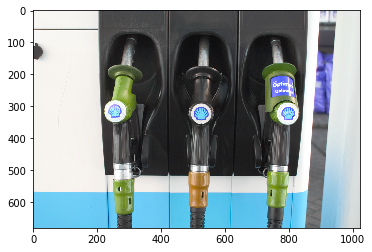

image_id      106310488.jpg
brand_name            shell
x                       775
y                       301
width                    49
height                   49
Name: 994, dtype: object


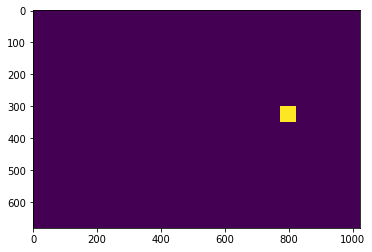

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

image_data = df[df['image_id'] == '106310488.jpg']
for index, row in image_data.iterrows():
    path = BASE_DATA_DIR + 'trainval_jpg/' + row['image_id']
    img = cv2.imread(path)
    img_width, img_heigth, channels = img.shape

    plt.imshow(img)
    plt.show()
    plt.pause(.01)
    mask = np.zeros((img_width, img_heigth))
    # print(row)
    mask[row['y']:row['y'] + row['width'], row['x']:row['x'] + row['height']] = 1
    plt.imshow(np.squeeze(mask))
    plt.show()
    plt.pause(.01)


In [0]:
print(len(df['brand_name'].unique()))
print(df['brand_name'].unique())
# print(df.groupby('brand_name').agg({'image_id':'count'}))
# print(df.groupby('image_id').agg({'brand_name': 'count'}))


for image_id in df['image_id'].unique():
    image_data = df[df['image_id'] == image_id]
    for (i, row) in image_data.iterrows():

In [0]:


class BrandsDataset(utils.Dataset):
    def load_data(self, brands, images):
        brand_dict = dict()
        for (i, brand) in enumerate(brands):
            self.add_class('brands', i, brand)
            brand_dict[brand] = i

        for (i, image_id) in enumerate(df['image_id'].unique()):
            image_data = df[df['image_id'] == image_id]
            brands = []
            for (i, row) in image_data.iterrows():
                brand_info = dict(
                    brand_id = brand_dict[row['brand_name']],
                    x = row['x'],
                    y = row['y'],
                    width = row['width'],
                    height = row['height'],
                )
                brands.append(brand_info)
            self.add_image(
                'brands', 
                image_id=image_id, 
                path=BASE_DATA_DIR + 'trainval_jpg/' + row['image_id'], 
                brands=brands,
            ) 

    def load_image(self, image_id):
        image_info = self.image_info[image_id]
        image = cv2.imread(image_info['path'])
        image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT))
        return image

    def load_mask(self, image_id):
        ## TODO move to load
        img = cv2.imread(path)
        img_width, img_heigth, channels = img.shape

        image_info = self.image_info[image_id]
        brand_ids = []
        masks = np.zeros([IMAGE_HEIGHT, IMAGE_WIDTH, len(image_info['brands'])], dtype=np.uint8)
        for (i, brand) in enumerate(image_info['brands']):
            mask = np.zeros([img_width, img_heigth, 1])
            mask[brand['y']:brand['y'] + brand['height'], brand['x']:brand['x'] + brand['width']] = 1
            mask = cv2.resize(mask, (IMAGE_HEIGHT, IMAGE_WIDTH))[..., np.newaxis]
            masks[:, :, i:i+1] = mask
            brand_ids.append(brand['brand_id'])

        return (masks, brand_ids)

bds = BrandsDataset()
bds.load_data(df['brand_name'].unique(), df['image_id'].unique())
bds.prepare()

1


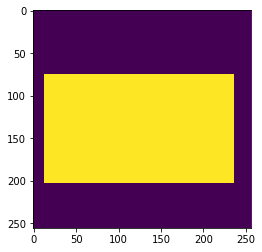

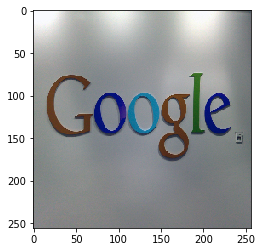

1


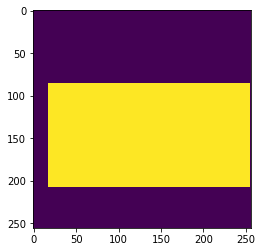

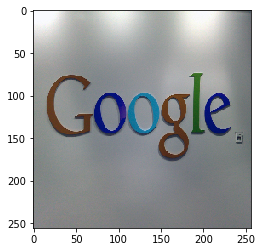

1


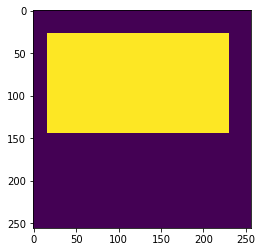

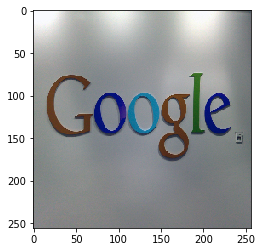

1


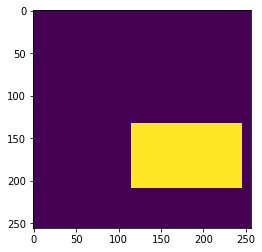

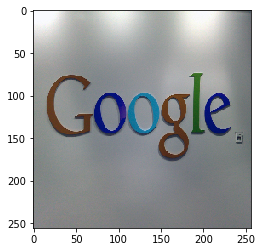

1


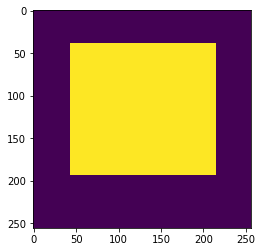

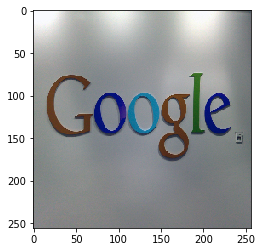

1


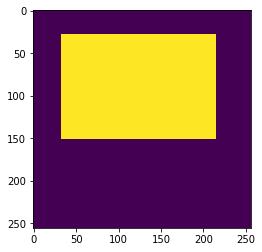

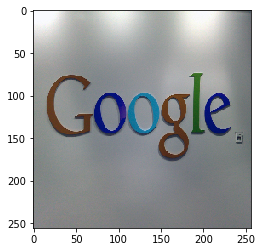

1


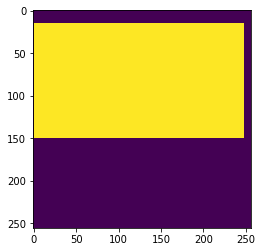

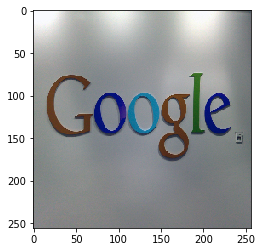

1


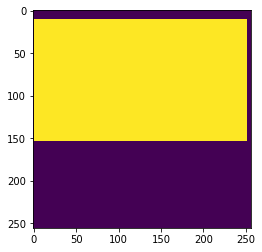

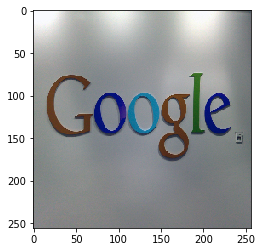

1


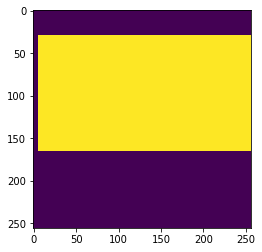

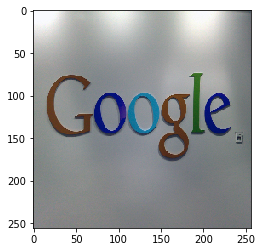

1


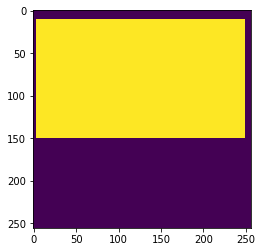

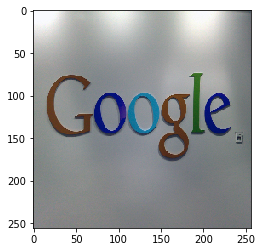

In [98]:
for i in range(10):
    masks, brand_ids = bds.load_mask(i)
    # print(brand_ids, masks)

    print(len(brand_ids))
    for i in range(len(brand_ids)):
        mask = masks[:, :, i]
        plt.imshow(mask)
        plt.show()

    plt.pause(.01)
    # print(bds._image_ids)

    plt.imshow(bds.load_image(i))
    plt.show()
    plt.pause(.01)

In [43]:
bds.__dict__.keys()

dict_keys(['_image_ids', 'image_info', 'class_info', 'source_class_ids'])

In [0]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 3, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask.astype(np.bool), class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes